In [1]:
import json
from PIL import Image, ImageFilter
import os
import numpy as np

In [2]:
all_pics = [f"./pics/{pic}" for pic in os.listdir("./pics")]

with open("./colors.json", "r") as color_file:
    manual_colors = json.load(color_file)

In [3]:
def hex_to_rgb(hex_color):
    rgb_color = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return [v / 255.0 for v in rgb_color]

def hex_to_hsl(hex_color):
    rgb_color = hex_to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(*rgb_color)
    h = h * 360 if h is not None else 0
    s = s * 100
    l = l * 100
    return [h, s, l]

def find_non_white_colors(path, white_threshold, saturation_threshold):
    name = path.split("/")[-1].split(".")[0]
    brand, treatment, fat_content = name.split("_")
    manual_color = manual_colors[name]
    img = Image.open(path)
    img.convert("RGB")
    img_array = np.array(img)
    pixels = img_array.reshape(-1, 3)
    
    img_hsv = img.convert('HSV')
    hsv_array = np.array(img_hsv).reshape(-1, 3)
    
    
    mask = (
        (np.max(pixels, axis=1) < white_threshold) &
        (hsv_array[:, 1] > saturation_threshold)
    )
    
    filtered_pixels = pixels[mask]

    if len(filtered_pixels) == 0:
        return (0, 0, 0)
    
    unique_colors, counts = np.unique(filtered_pixels, axis=0, return_counts=True)
    most_common_idx = np.argmax(counts)
    rgb_tuple = unique_colors[most_common_idx]
    auto_color = "{:02x}{:02x}{:02x}".format(rgb_tuple[0], rgb_tuple[1], rgb_tuple[2])
    datum = {
        "name": name,
        "brand": brand,
        "treatment": treatment,
        "fat_content": fat_content,
        "manual_color": manual_color,
        "manual_hsl": hex_to_hsl(manual_color),
        "auto_color": auto_color,
        "auto_hsl": hex_to_hsl(auto_color),
    }
    return datum

In [4]:
data = [find_non_white_colors(path, 200, 30) for path in all_pics]

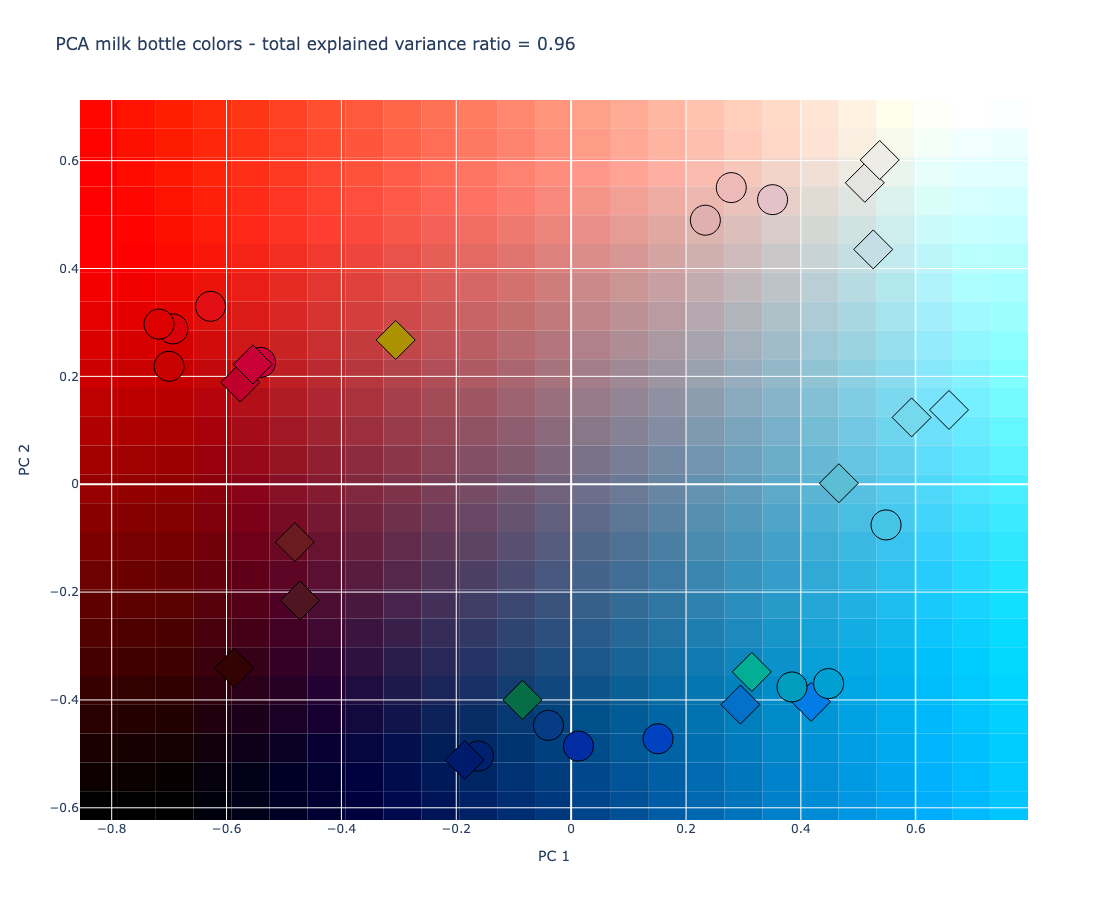

In [12]:
import plotly.express as px
import plotly.graph_objects as go
import io
import base64
from sklearn.decomposition import PCA

PLOT_WIDTH = 900
PLOT_HEIGHT = 900

def create_color_background(pca_model, x_range, y_range, resolution):
    x_grid = np.linspace(x_range[0], x_range[1], resolution)
    y_grid = np.linspace(y_range[0], y_range[1], resolution)
    
    X, Y = np.meshgrid(x_grid, y_grid)
    points_2d = np.column_stack([X.ravel(), Y.ravel()])
    
    points_3d = pca_model.inverse_transform(points_2d)
    points_3d *= 255.0
    
    points_3d_clipped = np.clip(points_3d, 0, 255).astype(int)
    hex_colors_bg = ['#%02x%02x%02x' % (r, g, b) for r, g, b in points_3d_clipped]
    
    return X, Y, np.array(hex_colors_bg).reshape(X.shape)


def plot_pca(data, color_type):
    pca = PCA(n_components=2)
    color_label = f"{color_type}_color"
    X = [hex_to_rgb(datum[color_label]) for datum in data]
    X = np.array(X)

    pca_results = pca.fit_transform(X)
    hex_colors = [f"#{datum[color_label]}" for datum in data]
    names = [datum["name"] for datum in data]
    symbols = ["diamond" if datum["fat_content"] == "intero" else "circle" for datum in data]

    min_x = min(pca_results[:, 0])
    max_x = max(pca_results[:, 0])
    min_y = min(pca_results[:, 1])
    max_y = max(pca_results[:, 1])

    x_padding = (max_x - min_x) * .1
    y_padding = (max_y - min_y) * .1

    x_range = [min_x - x_padding, max_x + x_padding]
    y_range = [min_y - y_padding, max_y + y_padding]

    X_bg, Y_bg, colors_bg = create_color_background(pca, x_range, y_range, 25)
    
    fig = go.Figure()

    fig.update_layout(
        xaxis=dict(range=x_range),
        yaxis=dict(range=y_range)
    )

    dx = (x_range[1] - x_range[0]) / colors_bg.shape[1]
    dy = (y_range[1] - y_range[0]) / colors_bg.shape[0]
    
    for i in range(colors_bg.shape[0]):
        for j in range(colors_bg.shape[1]):
            fig.add_shape(
                type="rect",
                x0=x_range[0] + j * dx,
                y0=y_range[0] + i * dy,
                x1=x_range[0] + (j + 1) * dx,
                y1=y_range[0] + (i + 1) * dy,
                fillcolor=colors_bg[i, j],
                line=dict(width=0),
                layer="below"
            )
    
    fig.add_trace(go.Scatter(
        x=pca_results[:, 0],
        y=pca_results[:, 1],
        mode='markers',
        marker=dict(
            size=30,
            color=hex_colors,
            line=dict(width=1, color='black'),
            symbol=symbols,
        ),
    ))

    tot_explained_variance = sum(pca.explained_variance_ratio_)
    fig.update_layout(
        title='PCA milk bottle colors - total explained variance ratio = %.2f' % tot_explained_variance,
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        showlegend=False,
        width=PLOT_WIDTH,
        height=PLOT_HEIGHT
    )
    fig.show()
    

plot_pca(data, "manual")